In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00


## ARIMA

In [2]:
#from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import pandas as pd
#from pmdarima.arima import auto_arima
import numpy as np
from scipy.stats import norm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def arima(test_week):
    quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
    data_file = '/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv'

    prediction_file = '/content/drive/MyDrive/RSV forecasting/Result/state level/'

    quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])


    df = pd.read_csv(data_file)
    df['fips'] = df['fips'].astype(str).str.zfill(2)
    df['Week_end'] = pd.to_datetime(df['Week_end'])
    df = df.drop(['PRCP_mean', 'SNOW_mean', 'TMAXDELTA', 'TMINDELTA','s05_value','scontrol_value'], axis=1)
    #df_train = df[(df['Week_end'] < pd.to_datetime(test_week)) & (df['Week_end'] > pd.to_datetime('2022-08-01'))]
    df_train = df[(df['Week_end'] < pd.to_datetime(test_week))]
    df_train['rsv_rate'] = np.log(df_train['rsv_rate'] + 1)

    test_states = df_train['fips'].unique()

    quantile_result = pd.DataFrame(columns=['fips', 'Week_end', 'horizon', 'Quantile', 'Value'])

    # Accumulate entries in a list
    results = []

    for fips in test_states:
        df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end').copy()

        #model = auto_arima(df_state_train['rsv_rate'], seasonal=False, stepwise=True,
        #                  suppress_warnings=True, error_action="ignore", trace=True, max_order=None, test="adf")

        #model = ARIMA(df_state_train['rsv_rate'], order=model.order)

        model = ExponentialSmoothing(df_state_train['rsv_rate'], trend='add', seasonal='add', seasonal_periods=52)

        model_fit = model.fit()


        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)
        residuals = model_fit.resid
        residual_std = np.std(residuals)

        for horizon in range(0, 4):
            scaled_std = residual_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts):
                results.append({
                    'fips': fips,
                    'Week_end': pd.to_datetime(test_week),
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)
                })


    quantile_result = pd.concat([quantile_result, pd.DataFrame(results)], ignore_index=True)
    pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')

    pop['fips'] = pop['fips'].astype(str).str.zfill(2)
    df = quantile_result.merge(pop, on='fips', how='inner')

    df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
    df.drop(columns=['population'], inplace=True)
    df['Value'][df['Value'] < 0] = 0
    quantile_result1 = df.copy()

    quantile_result1.rename(columns={
        'fips': 'location',
        'Week_end': 'reference_date',
        'horizon': 'horizon',
        'Quantile': 'output_type_id',
        'Value': 'value'
    }, inplace=True)
    quantile_result1['value'][quantile_result1['value'] < 0] = 0

    quantile_result1['target'] = 'wk inc flu hosp'

    quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

    quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
    quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

    quantile_result1['output_type'] = 'quantile'
    quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
    quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
    quantile_result1.to_csv(prediction_file + test_week + '_quantileresultexp.csv',index = False)

In [3]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-07', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list

for test_week in test_weeks:
    arima(test_week)

<ipython-input-2-04bf12499c2b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rsv_rate'] = np.log(df_train['rsv_rate'] + 1)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [ ]:
test_weeks

['2023-10-07',
 '2023-10-14',
 '2023-10-21',
 '2023-10-28',
 '2023-11-04',
 '2023-11-11',
 '2023-11-18',
 '2023-11-25',
 '2023-12-02',
 '2023-12-09',
 '2023-12-16',
 '2023-12-23',
 '2023-12-30',
 '2024-01-06',
 '2024-01-13',
 '2024-01-20',
 '2024-01-27',
 '2024-02-03',
 '2024-02-10',
 '2024-02-17',
 '2024-02-24']

### Plot

In [ ]:
import pandas as pd
quantile_result = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/state level/2023-12-16_quantileresultexp.csv')
quantile_result

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2023-12-16,wk inc flu hosp,0,2023-12-16,6,quantile,0.010,1570
1,2023-12-16,wk inc flu hosp,0,2023-12-16,6,quantile,0.025,1698
2,2023-12-16,wk inc flu hosp,0,2023-12-16,6,quantile,0.050,1815
3,2023-12-16,wk inc flu hosp,0,2023-12-16,6,quantile,0.100,1957
4,2023-12-16,wk inc flu hosp,0,2023-12-16,6,quantile,0.150,2059
...,...,...,...,...,...,...,...,...
1099,2023-12-16,wk inc flu hosp,3,2024-01-06,49,quantile,0.850,93
1100,2023-12-16,wk inc flu hosp,3,2024-01-06,49,quantile,0.900,110
1101,2023-12-16,wk inc flu hosp,3,2024-01-06,49,quantile,0.950,138
1102,2023-12-16,wk inc flu hosp,3,2024-01-06,49,quantile,0.975,167


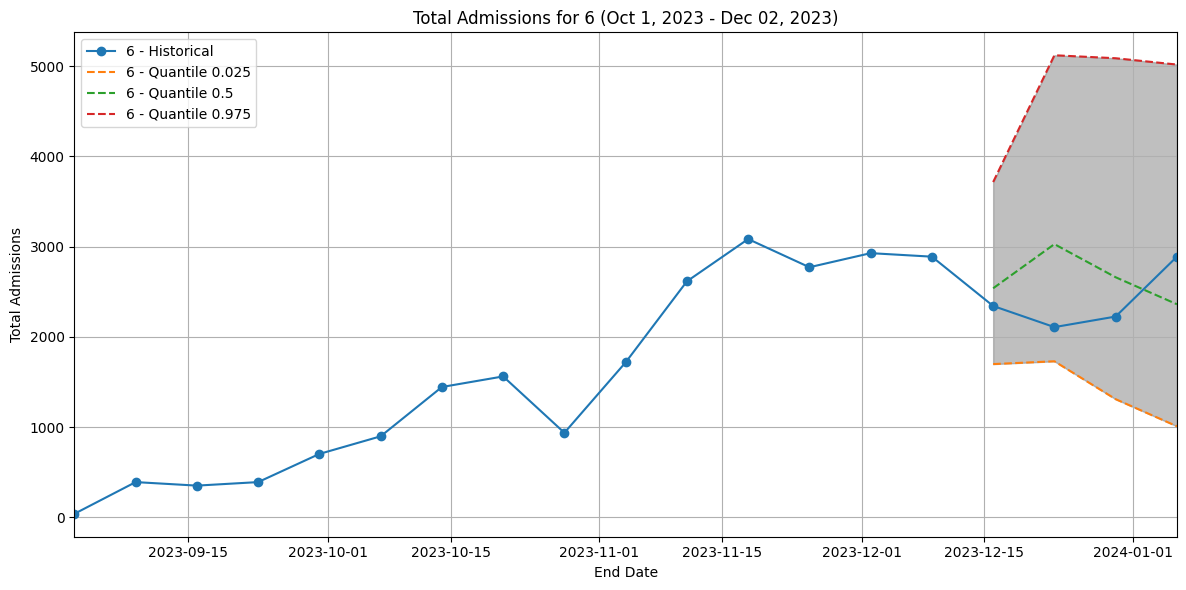

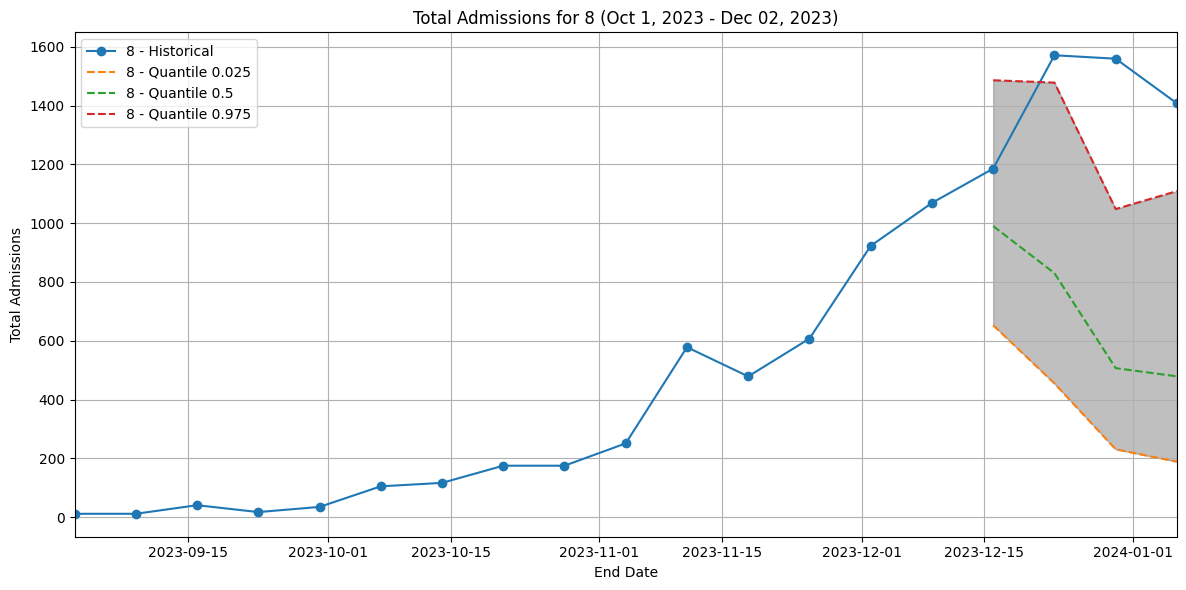

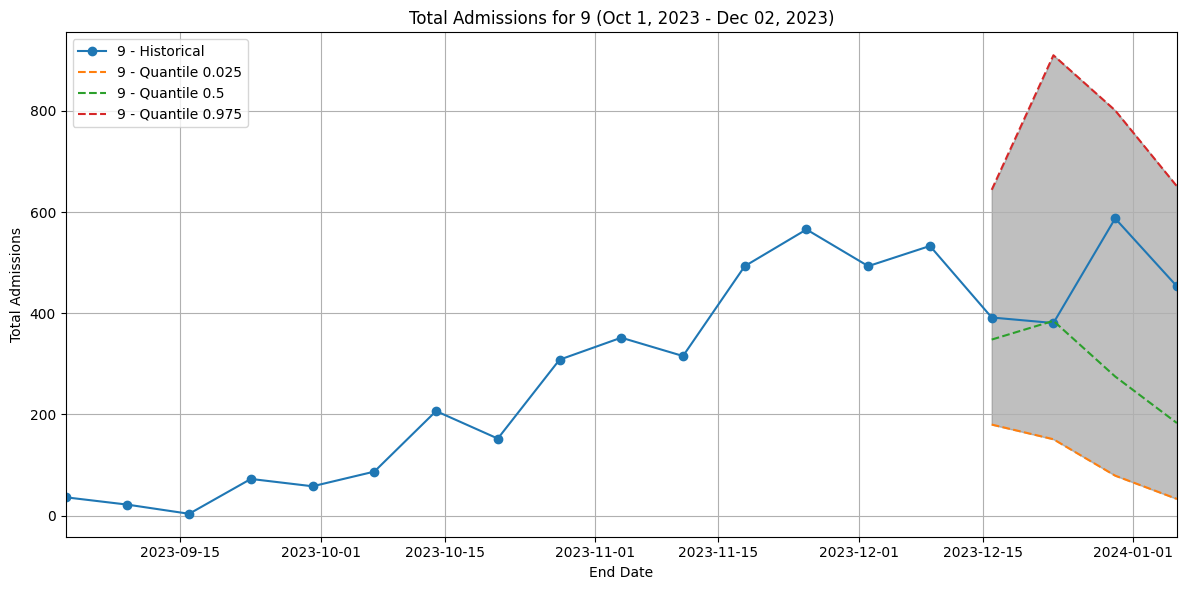

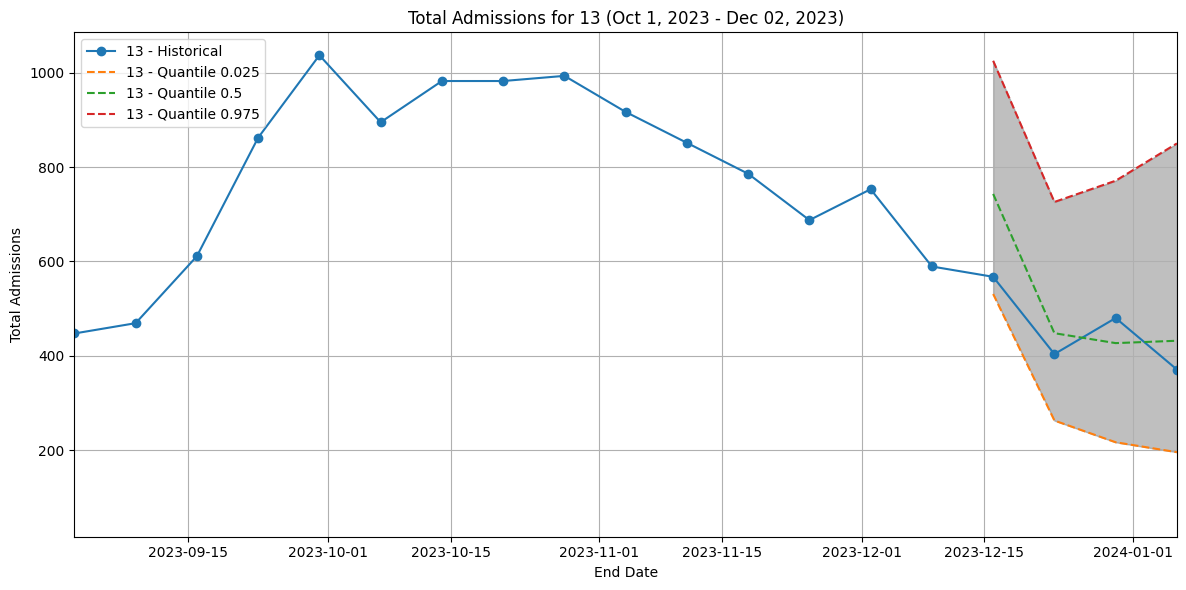

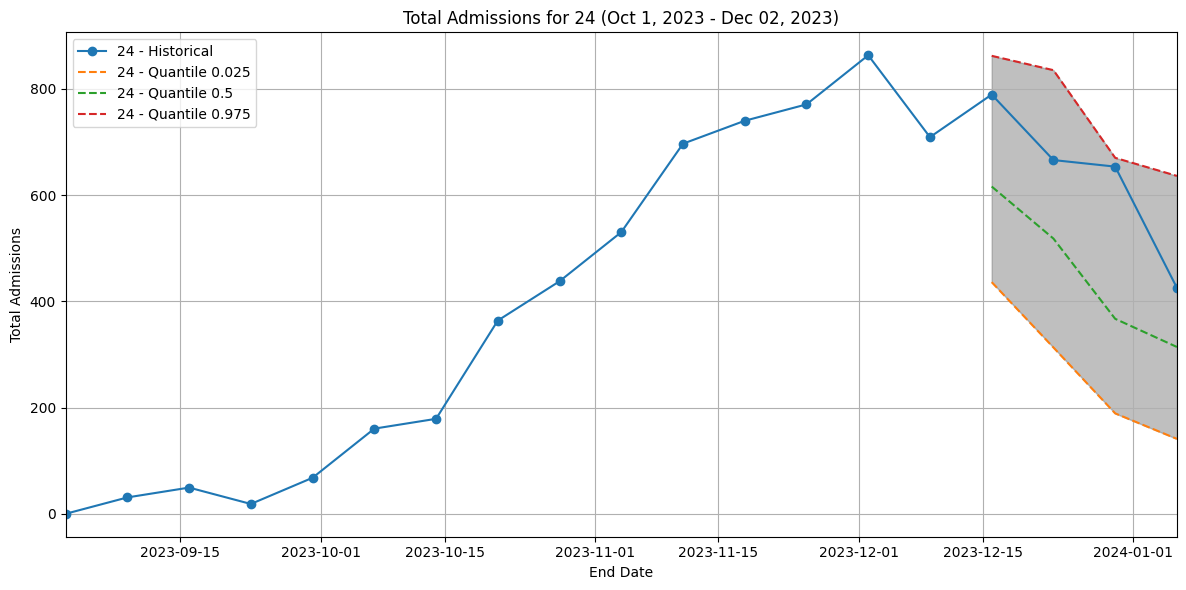

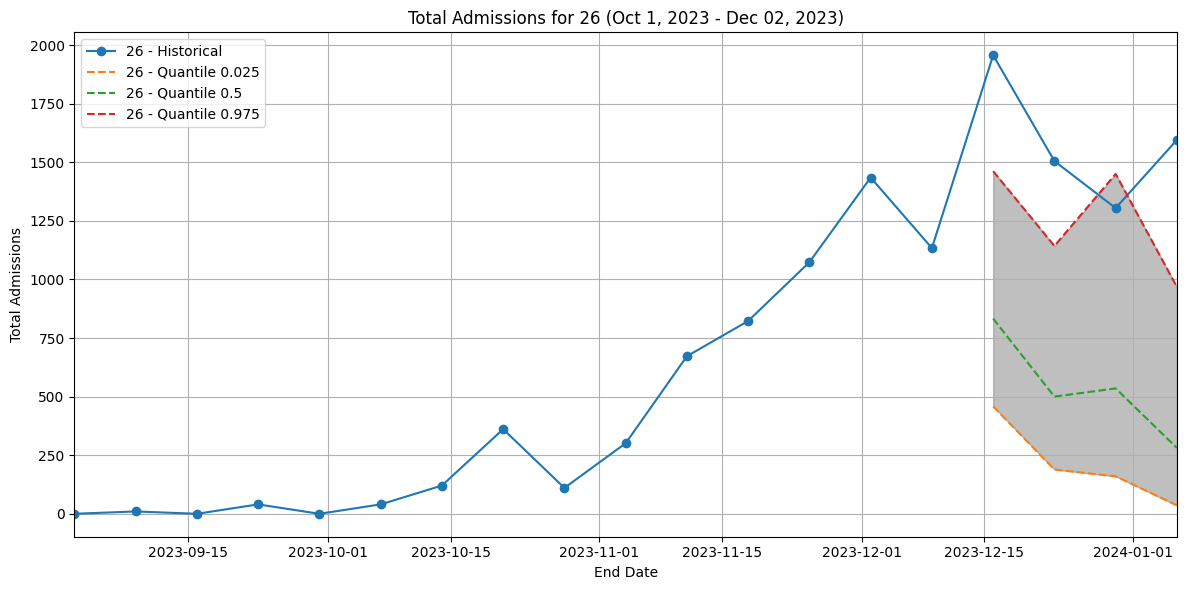

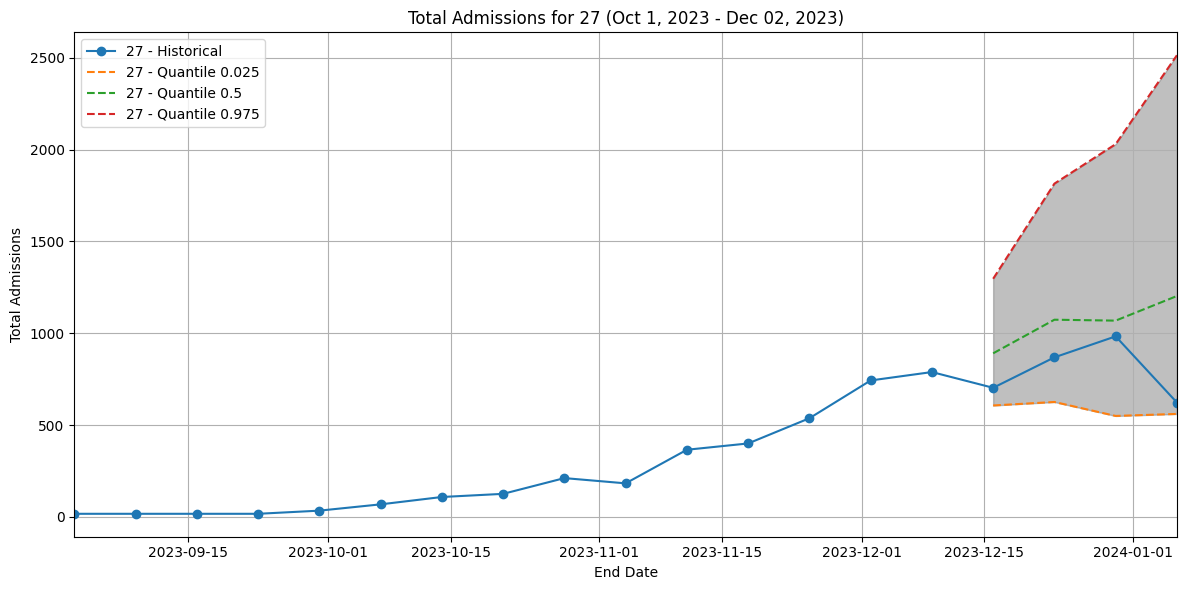

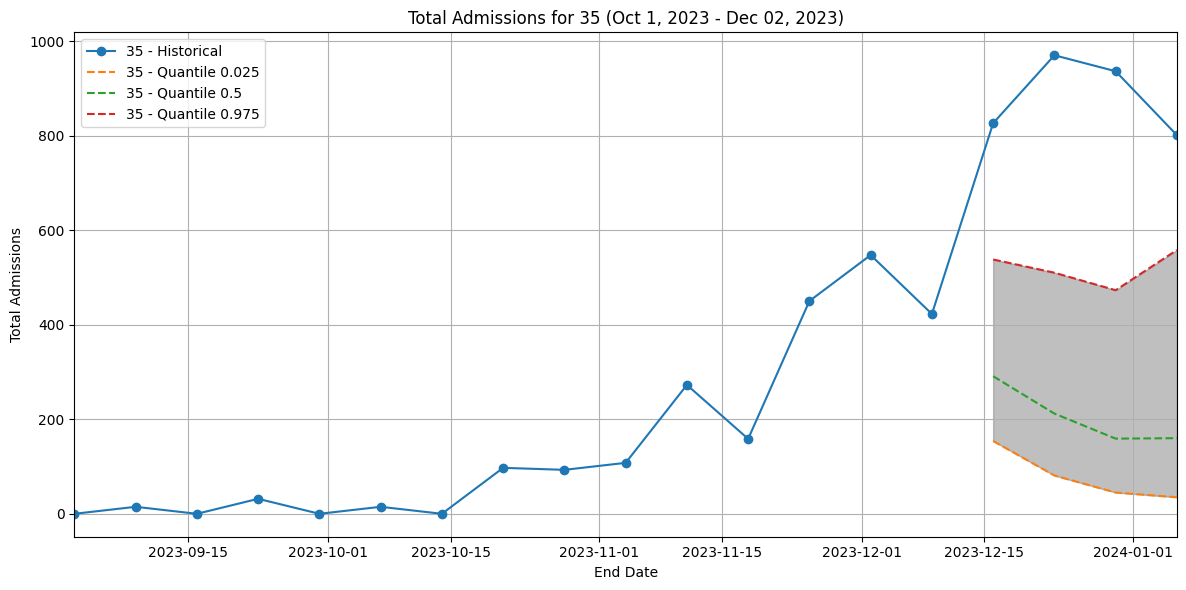

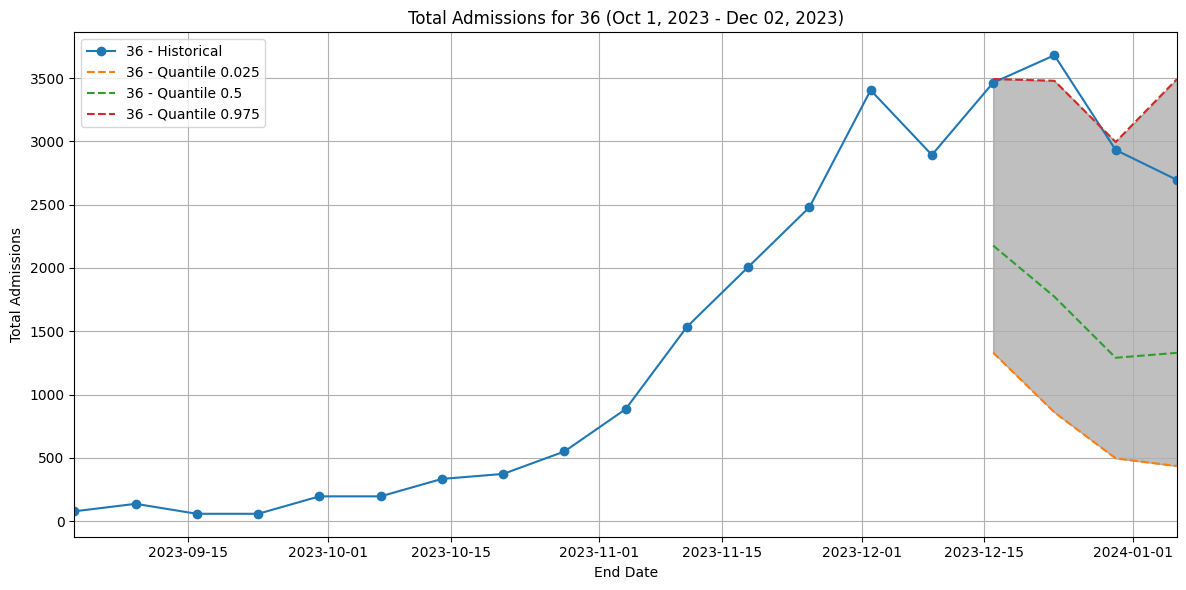

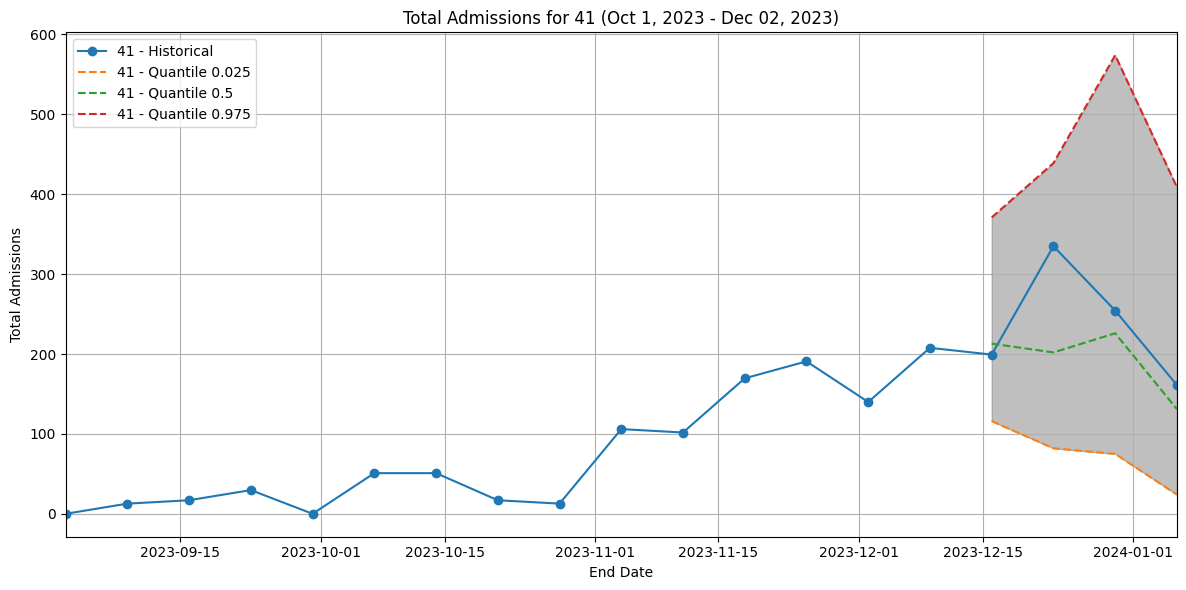

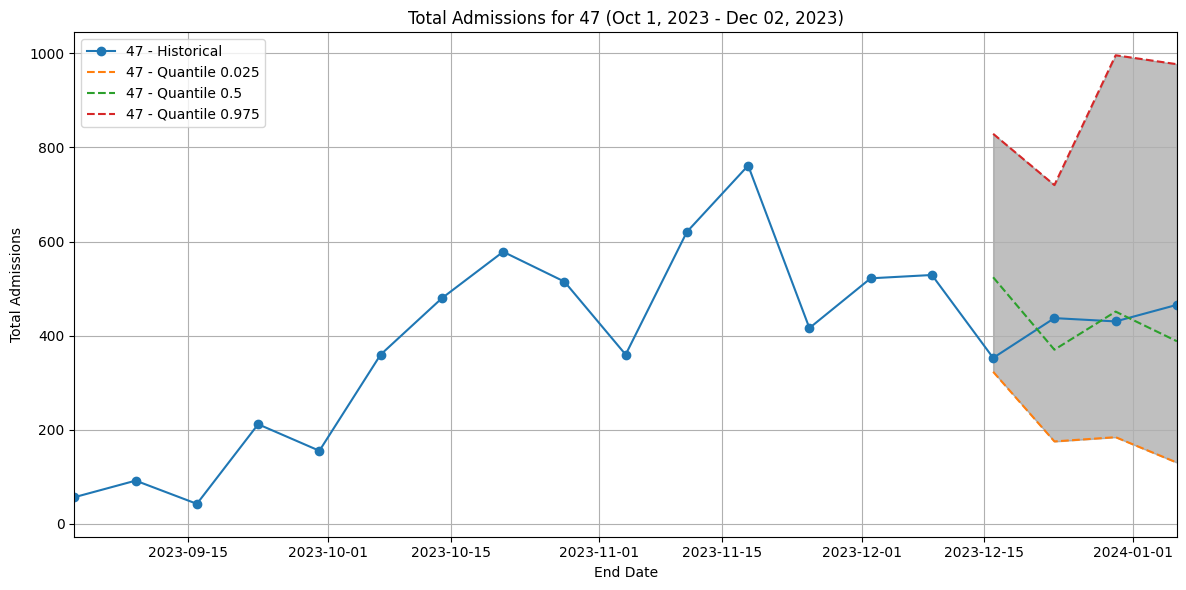

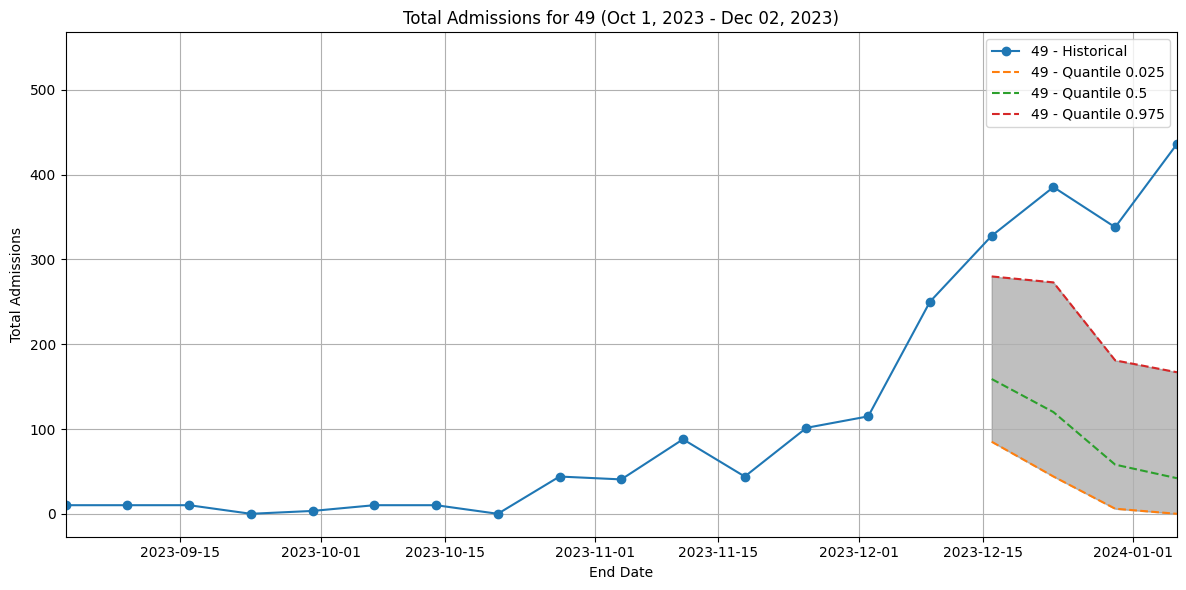

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/admission_withrsv.csv')
#hist = pd.read_csv('/Users/shawn/Flu Forecasting/code/trainingdata.csv')

import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result[quantile_result['reference_date'] == '2023-12-16']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
#hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-09-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-09-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['rsv_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# exponential smoothing(test)


Timestamp('2024-04-06 00:00:00')